# 1. Install PIP's

In [28]:
# Translator
%pip install googletrans==3.1.0a0

# geo files for Brazil
%pip install geobr
%pip install mapsmx
%pip install xgboost
%pip install sweetviz
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/1.5 MB ? eta -:--:--
     -                                        0.0/1.5 MB 991.0 kB/s eta 0:00:02
     --                                       0.1/1.5 MB 1.3 MB/s eta 0:00:02
     ---                                      0.1/1.5 MB 1.2 MB/s eta 0:00:02
     ---                                      0.1/1.5 MB 774.0 kB/s eta 0:00:02
     ----                                     0.2/1.5 MB 766.6 kB/s eta 0:00:02
     -----                                    0.2/1.5 MB 737.3 kB/s eta 0:00:02
     -----                                    0.2/1.5 MB 692.4 kB/s eta 0:00:02
     ------                                   0.2/1.5 MB 686.8 kB/s eta 0:00:02
     -------                                  0.3/1.5 MB 682.7 kB/s eta 0:00:02
     --------                                 0.3/1.5 MB 703.0 kB/s eta 0:00:02
     ---------                                0.4/1.5 MB 696.3 kB/s eta 0:00:02
     ----------                               0.4/1.5


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Import Packages

In [45]:
import pandas as pd
import os
import seaborn as sns
import nltk
import spacy
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# 3. Load Data

In [4]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wrangling

### 4.1. Merge Data and Drop Duplicates

In [5]:
full_df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

In [6]:
# Drop duplicates
full_df = full_df.drop_duplicates(subset=['review_id'])

In [7]:
full_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,8.0,13.0,9350,maua,SP,9350,-23.680114,-46.452454,maua,SP
207,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,b46f1e34512b0f4c74a72398b03ca788,4,...,8.0,13.0,9350,maua,SP,9350,-23.680114,-46.452454,maua,SP
414,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,dc90f19c2806f1abba9e72ad3c350073,5,...,8.0,13.0,9350,maua,SP,9350,-23.680114,-46.452454,maua,SP
621,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1bafb430e498b939f258b9c9dbdff9b1,3,...,8.0,13.0,9350,maua,SP,9350,-23.680114,-46.452454,maua,SP
828,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,b8238c6515192f8129081e17dc57d169,5,...,10.0,15.0,9350,maua,SP,9350,-23.680114,-46.452454,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16234780,8505d7267ce3f58c129ffa8468cebf21,af81a8c415a28b1ba710741f8e2562fe,processing,2017-02-15 23:00:16,2017-02-15 23:10:12,NaN,NaN,2017-04-04 00:00:00,df06641f8f60201aa235c5ee7a5205f4,2,...,12.0,33.0,2372,sao paulo,SP,2372,-23.459036,-46.623704,são paulo,SP
16234823,a6c258c89be1621b6e7c2bd85b4c866d,669a87ed9830ed7d79b3a22210a1a52d,delivered,2018-04-26 08:13:16,2018-04-26 08:32:43,2018-04-27 14:20:00,2018-05-08 22:51:35,2018-05-11 00:00:00,e59d582477716880d74d630e2e0fc6cb,4,...,11.0,11.0,1254,sao paulo,SP,1254,-23.541968,-46.681914,são paulo,SP
16234862,39e89b39b5cc8b5e3a38f23e915d1823,2b91bc260dcffbdacd12c4b09e5c7463,delivered,2017-07-24 11:29:43,2017-07-24 11:43:21,2017-07-24 22:34:38,2017-08-10 19:42:10,2017-08-23 00:00:00,e6de6c25dc2f6e602c1227e20756c992,5,...,7.0,11.0,2116,sao paulo,SP,2116,-23.522700,-46.587546,sao paulo,SP
16234875,f5f8998eee8ec7bc513dc52847d64ce0,f4656b824844a039a87fd9c51ad3586a,canceled,2018-03-01 11:42:23,2018-03-01 12:20:32,NaN,NaN,2018-03-20 00:00:00,bdf24af3e04cf534d9bee6afd037c1a0,1,...,20.0,20.0,13632,pirassununga,SP,13632,-22.004673,-47.415200,pirassununga,SP


### 4.2. Previus Analyze

In [8]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,97182,e481f51cbdc54678b7cc49136f2d6af7,16.57
1,customer_id,object,0,97182,9ef432eb6251297304e76186b10a928d,16.57
2,order_status,object,0,7,delivered,0.19
3,order_purchase_timestamp,object,0,96822,2017-10-02 10:56:33,16.56
4,order_approved_at,object,14,88940,2017-10-02 11:07:15,16.38
5,order_delivered_carrier_date,object,983,79858,2017-10-04 19:55:00,16.13
6,order_delivered_customer_date,object,2079,94319,2017-10-10 21:25:13,16.52
7,order_estimated_delivery_date,object,0,450,2017-10-18 00:00:00,8.46
8,review_id,object,0,97495,a54f0611adc9ed256b57ede6b6eb5114,16.57
9,review_score,int64,0,5,4,1.72


### 4.3. Filter Columns

In [9]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

df_filter = full_df.loc[:, selected_columns]
df_filter

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng
0,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
207,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
414,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
621,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38,87285b34884572647811a353c7ac498a,-23.680114,-46.452454
828,b8238c6515192f8129081e17dc57d169,5,NaN,"custo beneficio, simples de usar e rápido",2017-08-17 00:00:00,2017-08-21 12:43:27,b00a32a0b42fd65efb58a5822009f629,-23.680114,-46.452454
...,...,...,...,...,...,...,...,...,...
16234780,df06641f8f60201aa235c5ee7a5205f4,2,NaN,Ainda aguardo o produto. Após recebimento ou p...,2017-04-06 00:00:00,2017-04-06 09:50:52,9881e1d8024c8459494c134d29a42cd8,-23.459036,-46.623704
16234823,e59d582477716880d74d630e2e0fc6cb,4,Bom,Tudo certo!,2018-05-09 00:00:00,2018-05-10 10:36:39,5a68d72870a735b2e7ec0277013f7aa6,-23.541968,-46.681914
16234862,e6de6c25dc2f6e602c1227e20756c992,5,NaN,NaN,2017-08-11 00:00:00,2017-08-16 14:34:55,24fcd474105d95d2002f38f0cacf87ee,-23.522700,-46.587546
16234875,bdf24af3e04cf534d9bee6afd037c1a0,1,NaN,NaN,2018-03-22 00:00:00,2018-03-26 03:00:14,51bd37bb8517d5bfdb1f54c11fb01d27,-22.004673,-47.415200


In [10]:
df_metadata(df_filter)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,97495,a54f0611adc9ed256b57ede6b6eb5114,16.57
1,review_score,int64,0,5,4,1.72
2,review_comment_title,object,86058,4489,NaN,9.90
3,review_comment_message,object,57400,35625,"Não testei o produto ainda, mas ele veio corre...",14.78
4,review_creation_date,object,0,633,2017-10-11 00:00:00,8.76
5,review_answer_timestamp,object,0,97333,2017-10-12 03:43:48,16.57
6,product_id,object,0,31306,87285b34884572647811a353c7ac498a,13.59
7,geolocation_lat,float64,0,2226,-23.680114,8.92
8,geolocation_lng,float64,0,2226,-46.452454,8.92


### 4.4. Data Types Conversion

In [11]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
df_filter[datetime_columns] = df_filter[datetime_columns].apply(pd.to_datetime)

In [12]:
df_metadata(df_filter)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,97495,a54f0611adc9ed256b57ede6b6eb5114,16.57
1,review_score,int64,0,5,4,1.72
2,review_comment_title,object,86058,4489,NaN,9.90
3,review_comment_message,object,57400,35625,"Não testei o produto ainda, mas ele veio corre...",14.78
4,review_creation_date,datetime64[ns],0,633,2017-10-11 00:00:00,8.76
5,review_answer_timestamp,datetime64[ns],0,97333,2017-10-12 03:43:48,16.57
6,product_id,object,0,31306,87285b34884572647811a353c7ac498a,13.59
7,geolocation_lat,float64,0,2226,-23.680114,8.92
8,geolocation_lng,float64,0,2226,-46.452454,8.92


# 5. Exploratory Data Analysis

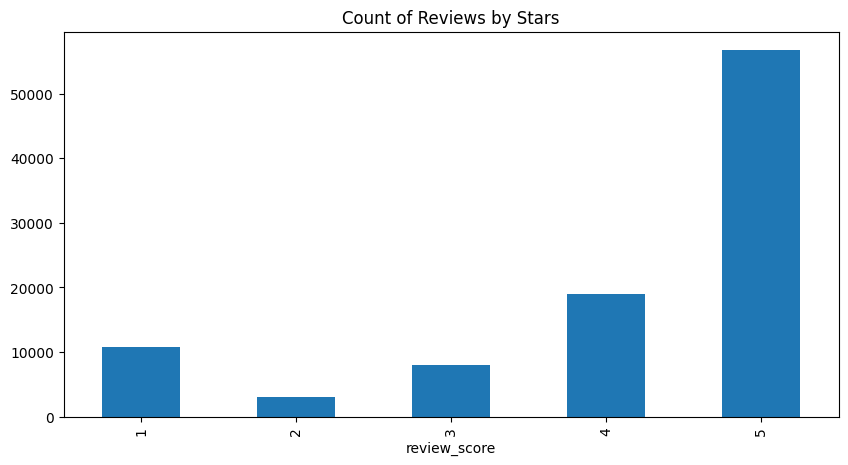

In [13]:
ax = df_filter['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10,5))


In [26]:
example = df_filter['review_comment_message'].iloc[1]
print(example)

Deveriam embalar melhor o produto. A caixa veio toda amassada e vou dar de presente. 


In [33]:
tokens = nltk.word_tokenize(example)
tokens [:10]

['Deveriam',
 'embalar',
 'melhor',
 'o',
 'produto',
 '.',
 'A',
 'caixa',
 'veio',
 'toda']

In [49]:
nlp = spacy.load('pt_core_news_sm')
tagged = nltk.pos_tag(tokens)
tagged[:10]

OSError: [E050] Can't find model 'pt_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

# 6. Clear Data Classification

In [77]:
selected_columns = ['review_id', 'review_score', 
                    'review_comment_message']

df_classification = full_df.loc[:, selected_columns]

In [78]:
import string
import re

# Criar uma cópia do DataFrame original
df_cleaned = df_classification.copy()

# Convertendo todas as strings da coluna 'review_comment_message' para minúsculas e removendo a pontuação
df_cleaned['review_comment_message'] = df_cleaned['review_comment_message'].str.lower().str.replace('[{}]'.format(re.escape(string.punctuation)), '', regex=True)


In [79]:
df_cleaned

,review_id,review_score,review_comment_message
0,a54f0611adc9ed256b57ede6b6eb5114,4,não testei o produto ainda mas ele veio corret...
207,b46f1e34512b0f4c74a72398b03ca788,4,deveriam embalar melhor o produto a caixa veio...
414,dc90f19c2806f1abba9e72ad3c350073,5,só achei ela pequena pra seis xícaras mais é u...
621,1bafb430e498b939f258b9c9dbdff9b1,3,NaN
828,b8238c6515192f8129081e17dc57d169,5,custo beneficio simples de usar e rápido
...,...,...,...
16234780,df06641f8f60201aa235c5ee7a5205f4,2,ainda aguardo o produto após recebimento ou po...
16234823,e59d582477716880d74d630e2e0fc6cb,4,tudo certo
16234862,e6de6c25dc2f6e602c1227e20756c992,5,NaN
16234875,bdf24af3e04cf534d9bee6afd037c1a0,1,NaN


In [80]:
df_tokenized = df_cleaned.copy()
df_tokenized['review_comment_message'] = df_tokenized['review_comment_message'].split()

AttributeError: 'float' object has no attribute 'split'